# CSR Zeuthen Benchmark - Comparing to Bmad


This tries to replicate the Zeuthern CSR benchmark according to:
https://journals.aps.org/prab/abstract/10.1103/PhysRevSTAB.16.060703


In [1]:
import numpy as np
import impact.z as IZ
from impact.z.interfaces.bmad import export_particles as tao_export_particles
from pytao import Tao

from pmd_beamphysics import ParticleGroup
import tempfile
from impact.tests.z.conftest import bmad_files

from scipy.constants import c

import pandas as pd

import matplotlib.pyplot as plt

In [2]:
TRACK_START = 'BEGINNING'
TRACK_END = 'END'

NZ = 128
N_PARTICLE = 10_000
DS_STEP = .01

DRIFT_CSR_ON = False

In [3]:
# Gaussian
def set_gaussian(tao,
    n_particle = 10_000,
    a_norm_emit = 1.0e-6  ,
    b_norm_emit = 1.0e-6 , 
    bunch_charge = 1e-9,
    sig_pz = 2e-6,
    sig_z = 200e-6,
    center_pz = 0,
    ):

    cmds = [
            f"set beam_init n_particle = {n_particle}",
            "set beam_init random_engine = quasi",
            "set beam_init saved_at = MARKER::*, BEGINNING, END",
            f"set beam_init a_norm_emit = {a_norm_emit}",
            f"set beam_init b_norm_emit = {b_norm_emit}",
            f"set beam_init bunch_charge = {bunch_charge}",
            f"set beam_init sig_pz = {sig_pz}",
            f"set beam_init sig_z = {sig_z}",
    
            #"set space_charge_com ds_track_step = 0.01",
            #"set space_charge_com n_bin = 40",
            f"set beam_init center(6) = {center_pz}",
        ]
    tao.cmds(cmds)
    tao.cmd('set global lattice_calc_on = T')

def track_tao(tao, particles):
    cmds = [
    f'set beam_init bunch_charge = {particles.charge}',
    f'set beam_init n_particle = {particles.n_particle}',
    f'set beam_init track_start = {TRACK_START}',
    f'set beam_init track_end = {TRACK_END}',
    "set beam_init saved_at = MARKER::*, BEGINNING, END",
    ]
    
    for cmd in cmds:
        print(cmd)
    tao.cmds(cmds)        
    
    with tempfile.NamedTemporaryFile(suffix=".h5") as temp_file:
        particles.write(temp_file.name)
        tao.cmd(f'set beam_init position_file = {temp_file.name}')       
        tao.cmd('set global lattice_calc_on = T')
        tao.cmd('set global track_type=beam;set global track_type=single')
        
    P1 = ParticleGroup(data = tao.bunch_data(TRACK_END))
    return P1    

def apply_chirp(pg: ParticleGroup, h):
    pg = pg.copy()
    p0 = pg['mean_p']
    z = -pg.beta * c * (pg.t -pg['mean_t'])
    pg.pz += ( h * z) * p0    
    return pg

(np.float64(5000000000.000002), np.float64(5000000000.001373))

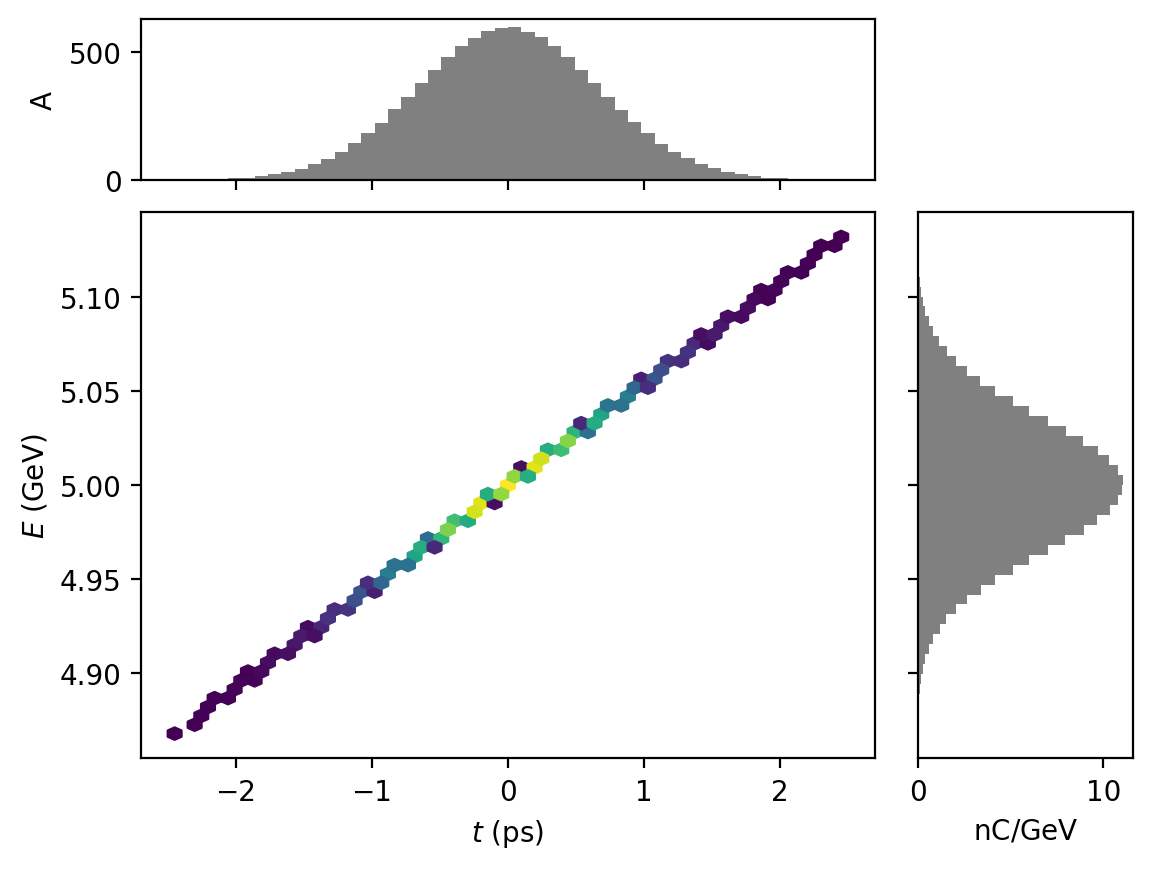

In [4]:
tao = Tao(lattice_file=bmad_files / "csr_zeuthen.bmad", plot="mpl")
set_gaussian(tao, n_particle = N_PARTICLE)
tao.cmd("set global track_type = beam; set global track_type = single")
P00 = ParticleGroup(data=tao.bunch_data('beginning'))
P0 = apply_chirp(P00, -36) 
P0.plot('t', 'energy')
P00['mean_energy'], P0['mean_energy']

In [5]:
tao.cmd('set bmad_com csr_and_space_charge_on = T')
tao.cmd(f'set space_charge n_bin = {NZ}')
tao.cmd(f'set space_charge ds_track_step = {DS_STEP}')
tao.cmd('set bmad_com radiation_damping_on  = T') # off by default
tao.cmd('set bmad_com radiation_fluctuations_on = T') # off by default
tao.cmd('set ele * space_charge_method = fft_3d')
tao.cmd(f'set space_charge space_charge_mesh_size = 32 32 {NZ}')
tao.cmd(f'set ele * DS_STEP = {DS_STEP}')

[]

In [6]:
if DRIFT_CSR_ON:
    tao.cmd('set ele * csr_method = 1_dim')
else:
    tao.cmd('set ele * csr_method = off')
    tao.cmd('set ele sbend::* csr_method = 1_dim')  

set beam_init bunch_charge = 9.999999999999999e-10
set beam_init n_particle = 10000
set beam_init track_start = BEGINNING
set beam_init track_end = END
set beam_init saved_at = MARKER::*, BEGINNING, END
CPU times: user 5min 19s, sys: 3.69 s, total: 5min 23s
Wall time: 50.7 s


(None, np.float64(20.27018141102658))

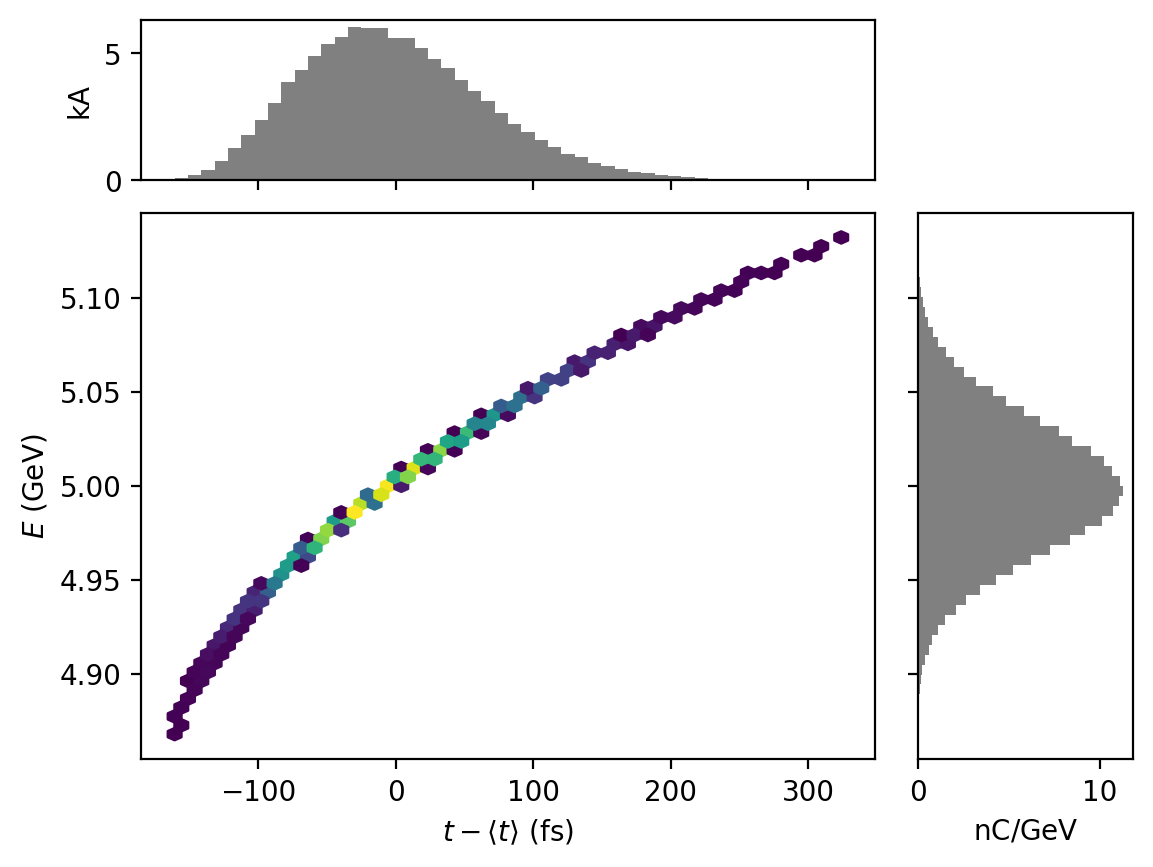

In [7]:
%%time
P1 = track_tao(tao, P0)

P1.plot('delta_t', 'energy'), P1['sigma_t'] * c * 1e6

In [8]:
sigma_z0 = P0['sigma_t'] *c
sigma_z1 = P1['sigma_t'] *c

sigma_z1 * 1e6

np.float64(20.27018141102658)

In [9]:
sigma_z1 / sigma_z0

np.float64(0.1013509065258383)

# Impact-Z

In [10]:
input = IZ.ImpactZInput.from_tao(tao, verbose=False, write_beam_eles="")
I = IZ.ImpactZ(input, use_temp_dir=False, workdir="./tmp-csr-bench")
I.initial_particles = P0

In [11]:
I.input.space_charge_on()
I.input.integrator_type = 1
I.input.nz = NZ

if DRIFT_CSR_ON:
    icsr = 501
else:
    icsr = 201
I.input.dipoles.input_switch = icsr
I.input.dipoles.input_switch

I.input.dipoles.fint = 0.5

In [12]:
%%time
I.nproc = 12
I.run(verbose=False);

<!-- lume-impact detected Jupyter and will use HTML for rendering. -->

  0%|          | 0/12 [00:00<?, ?it/s]

CPU times: user 979 ms, sys: 43.5 ms, total: 1.02 s
Wall time: 48.6 s


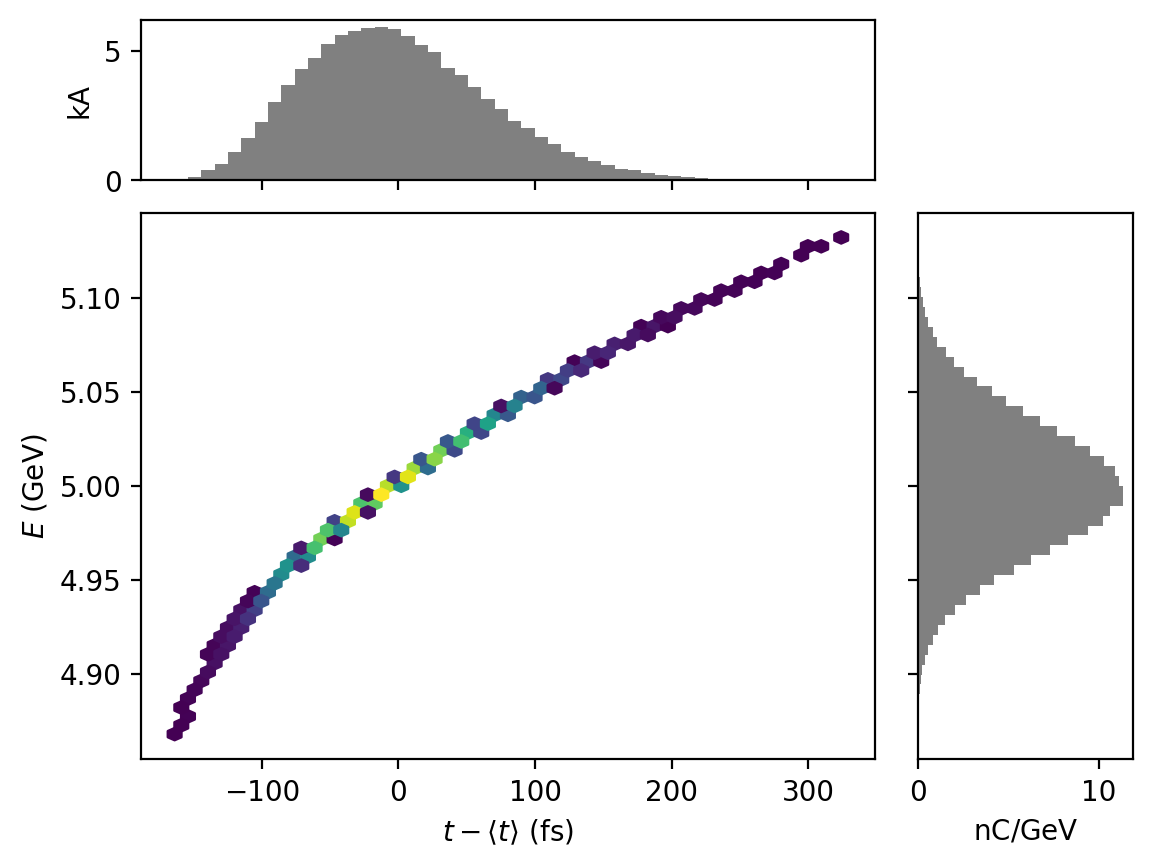

In [13]:
P2 = I.output.particles["final_particles"]
P2.plot("delta_t", "energy")

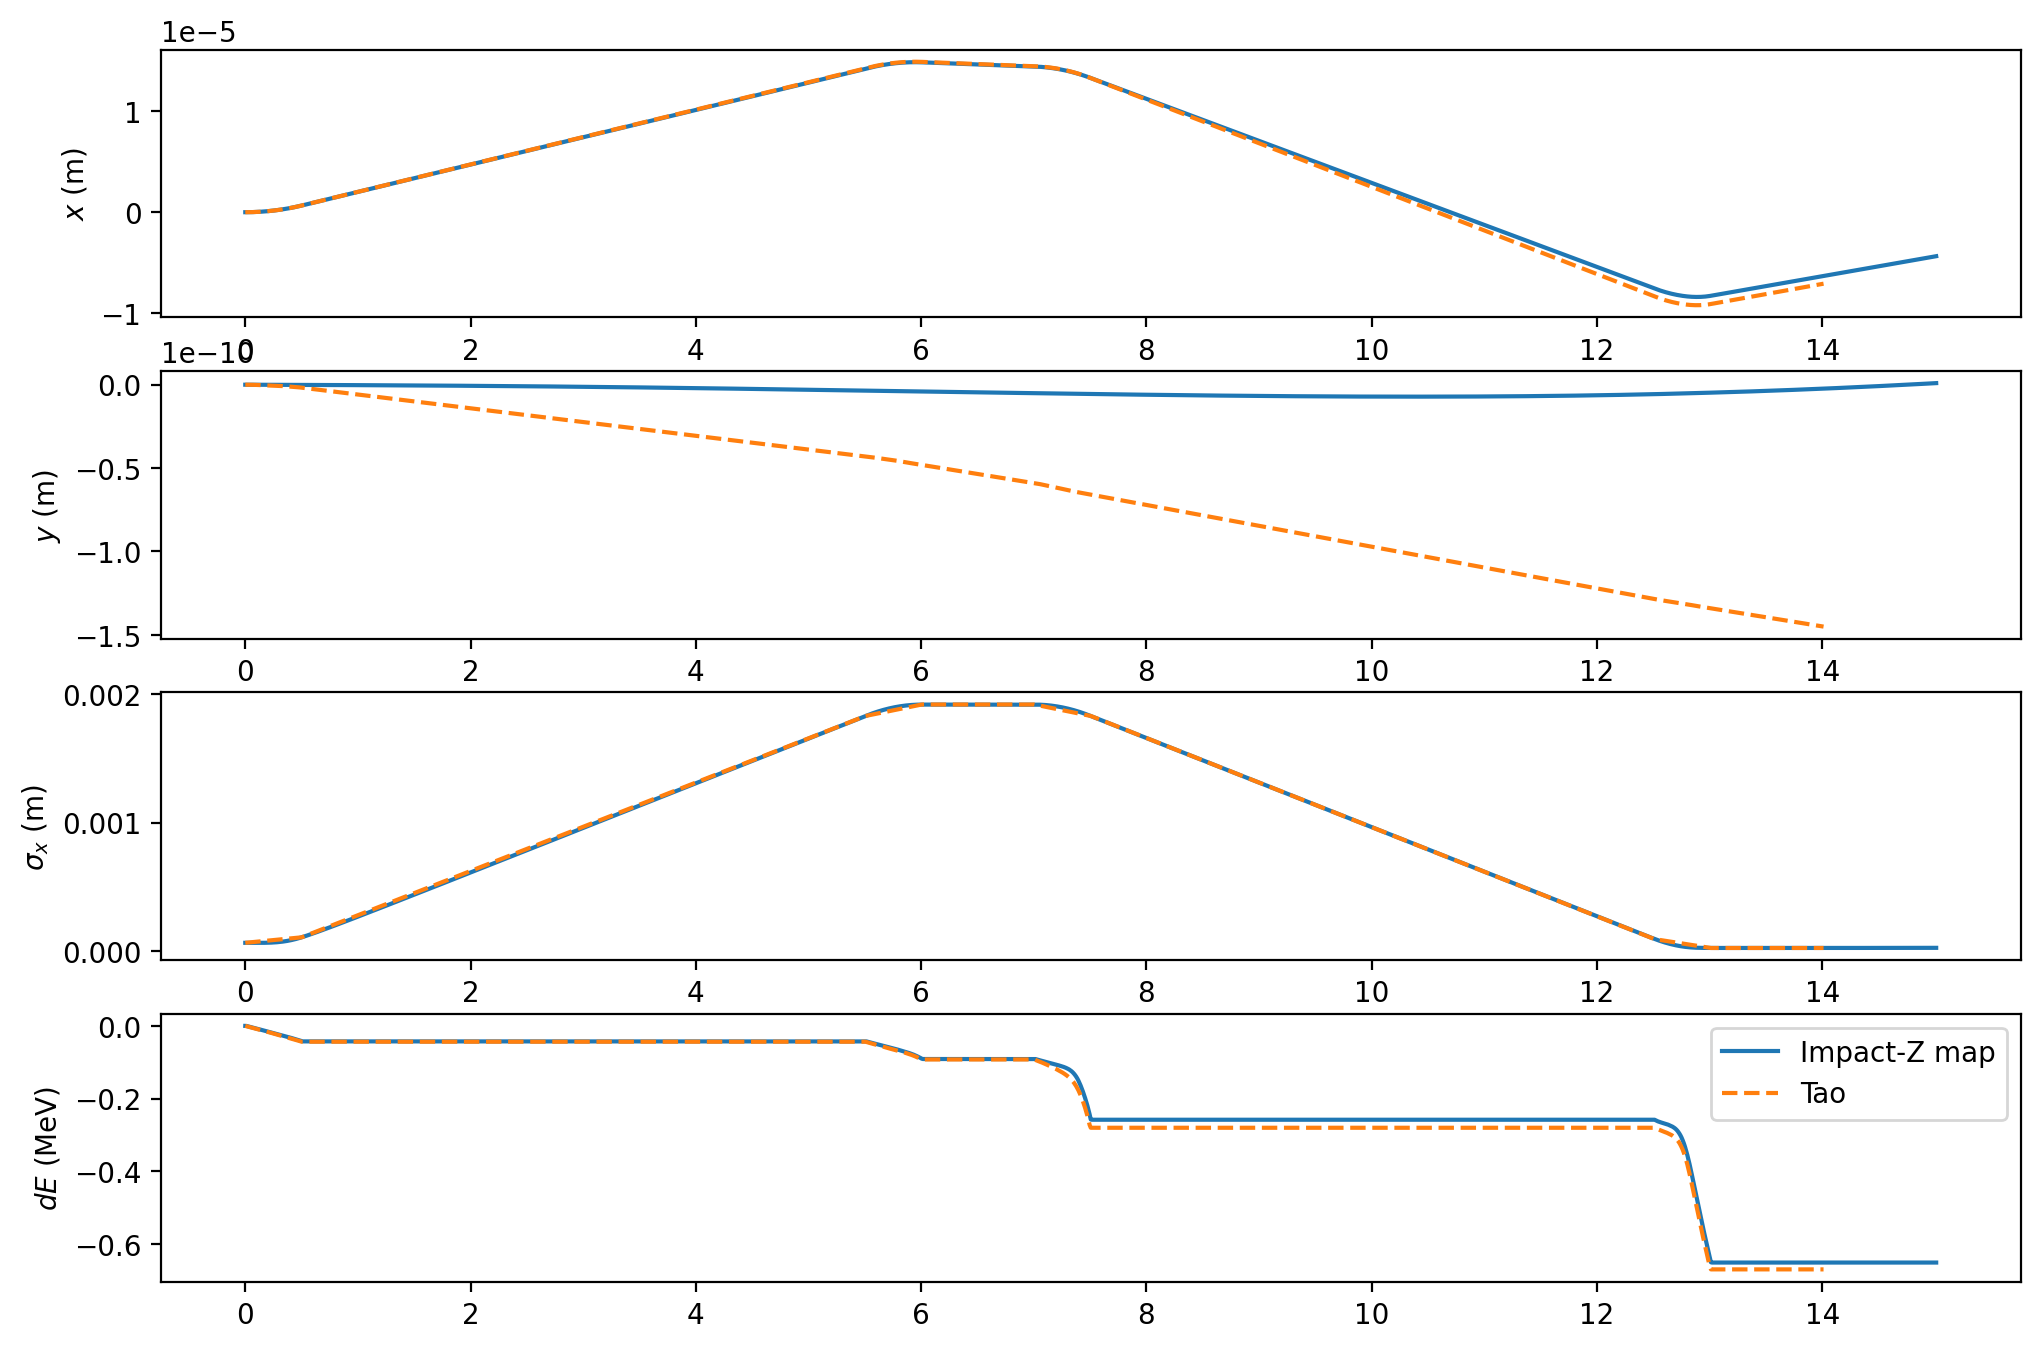

In [14]:
stats = I.output.stats
mc2 = I.input.reference_particle_mass
z = stats.z
x = stats.mean_x
y = stats.mean_y
sigma_x = I.output.stats.sigma_x
sigma_y = I.output.stats.sigma_y
energy = stats.mean_energy

ix_eles = tao.lat_list(f'{TRACK_START}:{TRACK_END}', 'ele.ix_ele')

bparams = pd.DataFrame(list(map(tao.bunch_params, ix_eles)))


x_tao = tao.bunch_comb("x")
y_tao = tao.bunch_comb("y")
sigma_x_tao = tao.bunch_comb("x.sigma")
sigma_y_tao = tao.bunch_comb("y.sigma")
p_tao = (1 + tao.bunch_comb("pz")) * tao.bunch_comb("p0c")
energy_tao = np.hypot(p_tao, mc2)
s_tao = tao.bunch_comb("s")
s_tao = s_tao - s_tao[0]


s_tao2 = bparams.s - bparams.s[0]
sigma_x_tao2 = np.sqrt(bparams.sigma_11)
sigma_y_tao2 = np.sqrt(bparams.sigma_33)

fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, figsize=(12, 8))

ax0.plot(z, x, label="Impact-Z")
ax0.plot(s_tao, x_tao, "--", label="Tao")
ax0.set_ylabel(r"$x$ (m)")

ax1.plot(z, y, label="Impact-Z")
ax1.plot(s_tao, y_tao, "--", label="Tao")
ax1.set_ylabel(r"$y$ (m)")

ax2.plot(z, sigma_x, label="Impact-Z")
#ax2.plot(s_tao, sigma_x_tao, "--", label="Tao")
ax2.plot(s_tao2, sigma_x_tao2, "--", label="Tao")
ax2.set_ylabel(r"$\sigma_x$ (m)")
#ax2.set_yscale('log')

ax3.plot(z, (energy - energy[0]) / 1e6, label="Impact-Z map")
ax3.plot(s_tao, (energy_tao - energy_tao[0]) / 1e6, "--", label="Tao")
ax3.set_ylabel(r"$dE$ (MeV)")

ax1.set_xlabel(r"$s$ (m)")

plt.legend();

## Compare

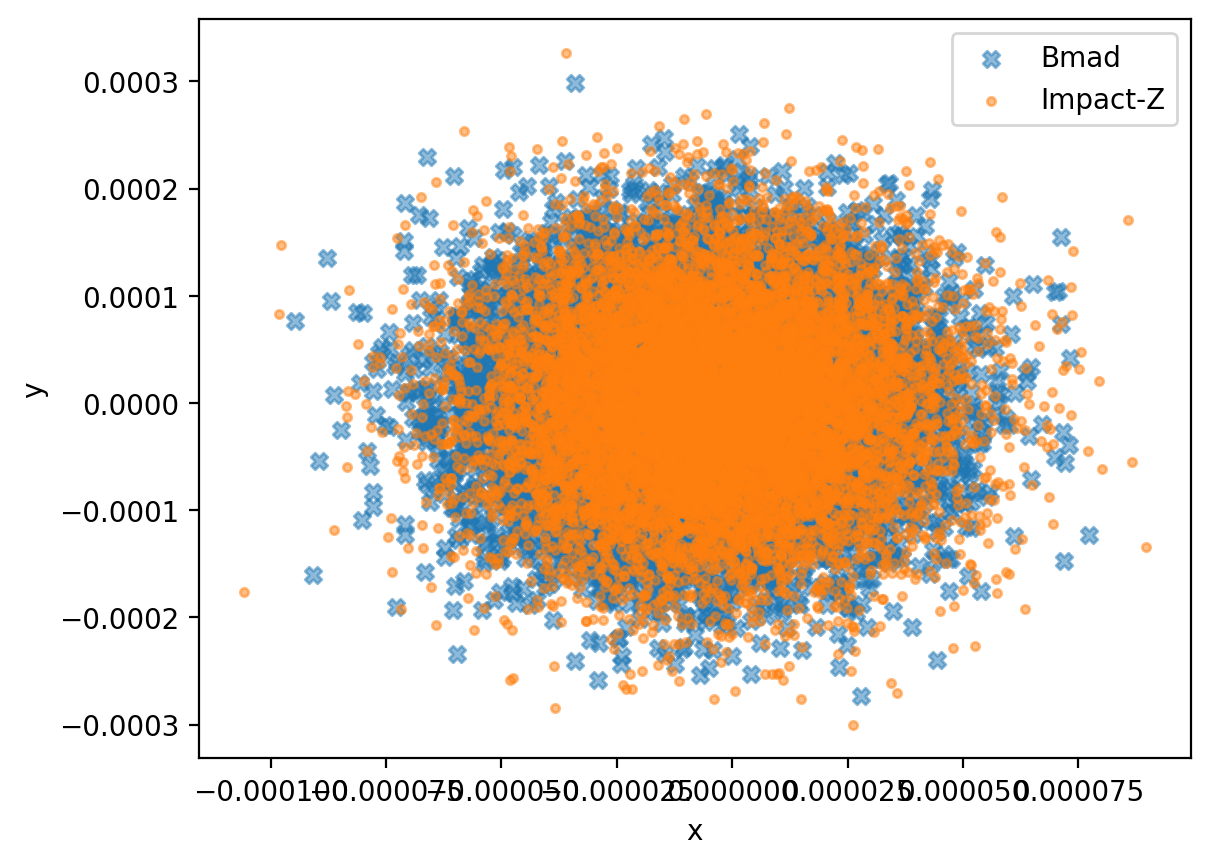

In [15]:
def compare(xkey = 'x',
            ykey = 'y',
            
            
           ):
    fig, ax = plt.subplots()
    
    
    for p, label, marker in ( 
                (P1, 'Bmad', 'X'),
                (P2, 'Impact-Z', '.'),
        ):
        ax.scatter(p[xkey], p[ykey], label=label, marker=marker, alpha=0.5)
    
    plt.legend()
    
    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)

compare()

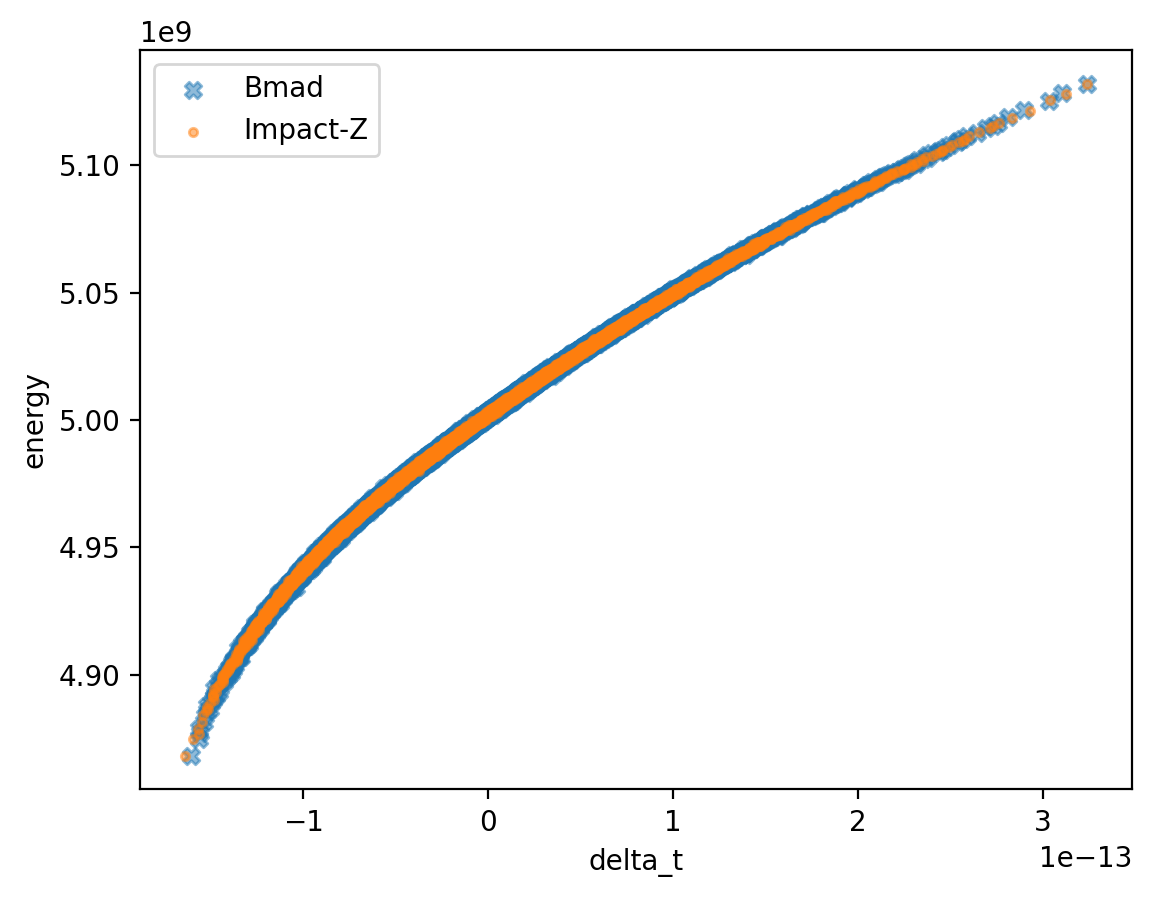

In [16]:
compare('delta_t', 'energy')

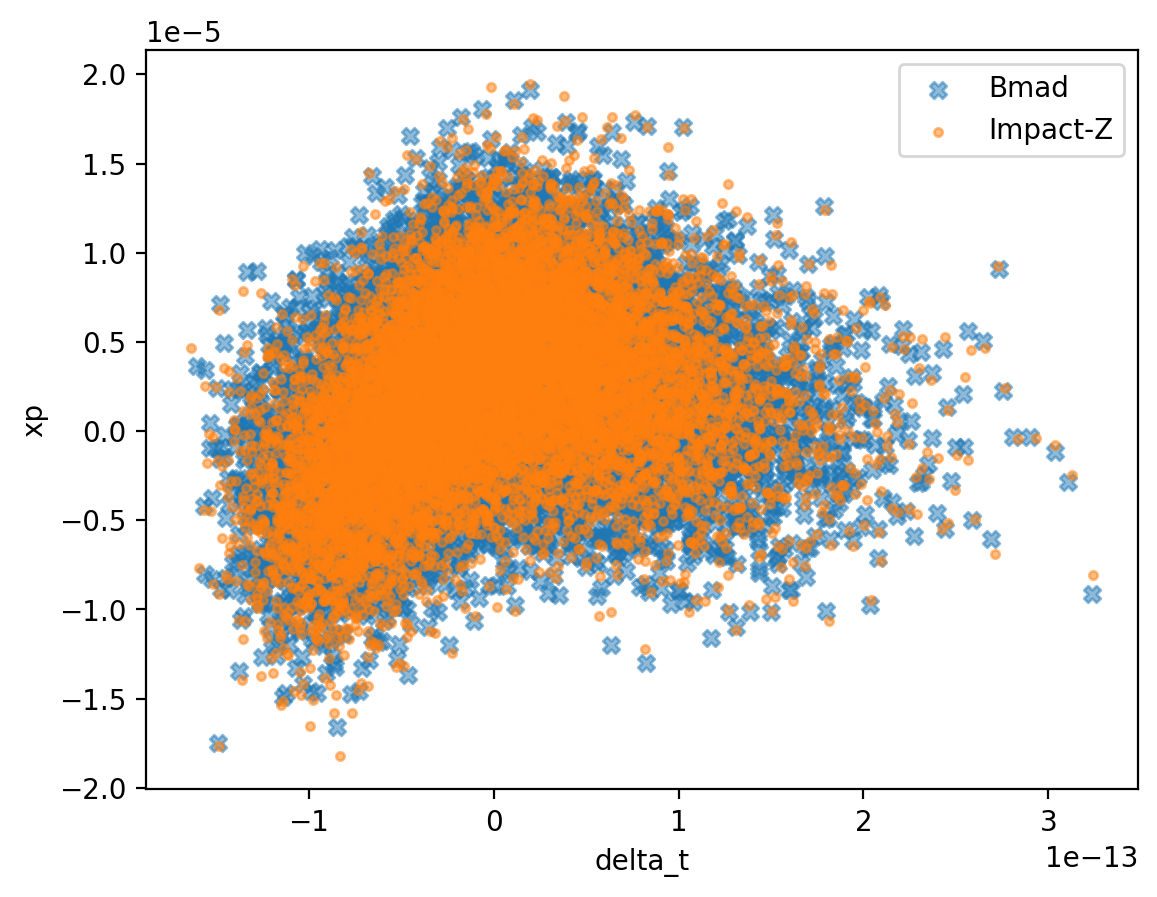

In [17]:
compare('delta_t', 'xp')

In [18]:
energy0 = P0['mean_energy']
P1['mean_energy'] -energy0,  P2['mean_energy'] - energy0

(np.float64(-668941.7885713577), np.float64(-639558.9737005234))

# Impact-Z Lorentz integrator 

`ImpactZInput.integrator_type = 2`

Note that this is not expected to work as well because the dipole fringe fields are not able to be specified.

In [19]:
I2 = I.copy()

In [20]:
I2.input.integrator_type = 2
I2.run(verbose=False);

P3 = I2.output.particles["final_particles"]

  0%|          | 0/12 [00:00<?, ?it/s]

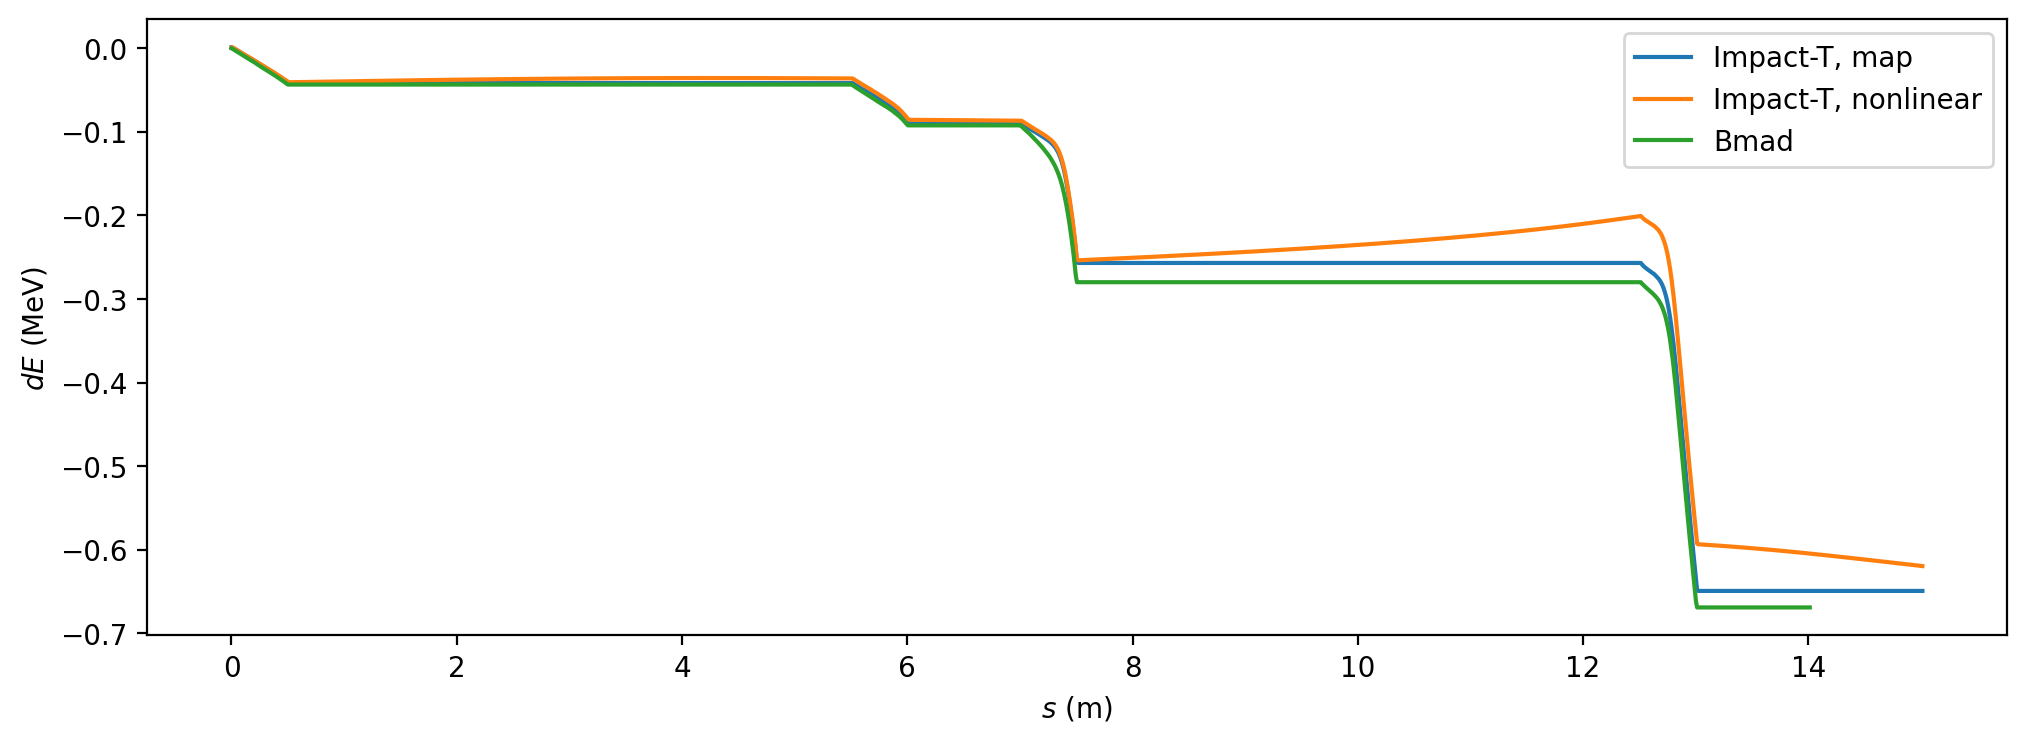

In [21]:
stats1 = I.output.stats
stats2 = I2.output.stats

eref = 5000e6

fig, ax = plt.subplots(1, figsize=(12, 4))

ax.plot(stats1.z, (stats1.mean_energy- eref)/1e6, label='Impact-T, map')
ax.plot(stats2.z, (stats2.mean_energy- eref)/1e6, label='Impact-T, nonlinear')

ax.plot(s_tao, (energy_tao -eref)/1e6, label='Bmad')

ax.set_xlabel(r"$s$ (m)")
ax.set_ylabel(r"$dE$ (MeV)")

plt.legend()

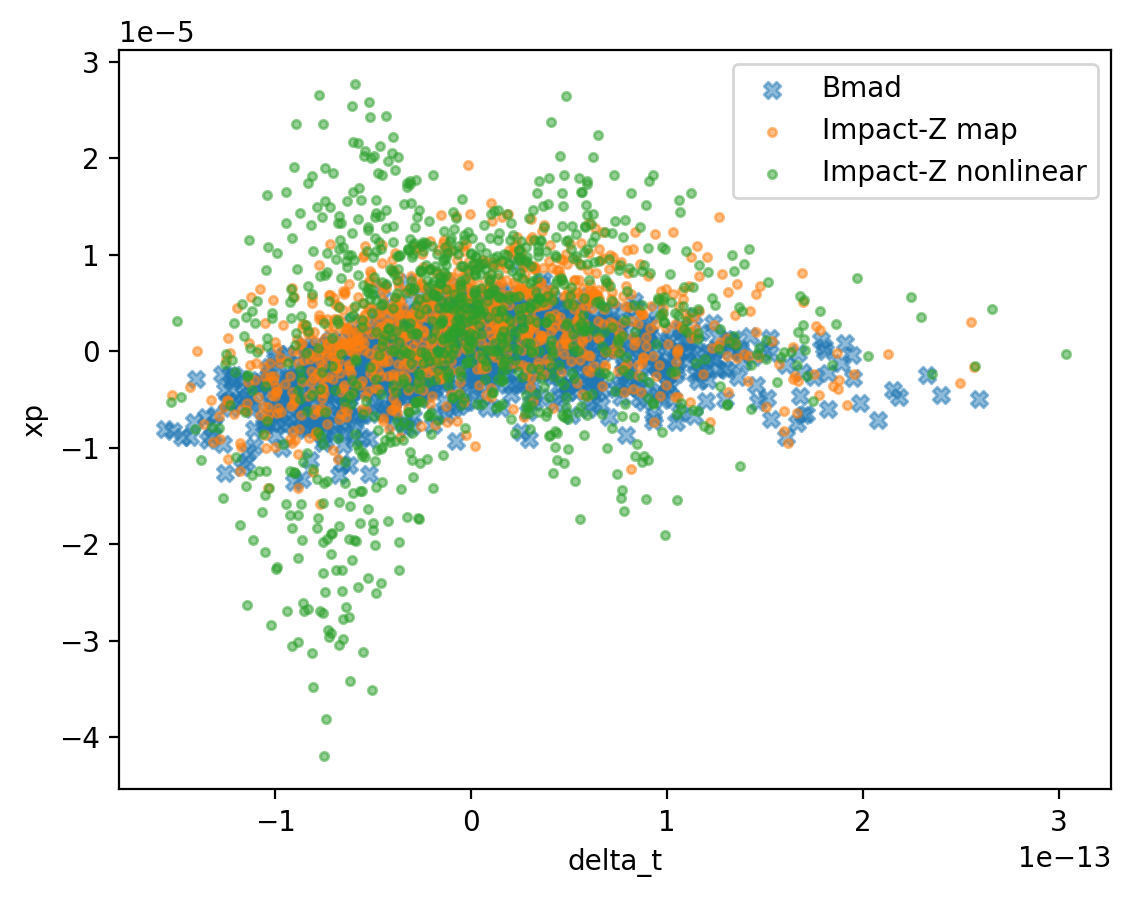

In [25]:
def compare(xkey = 'x',
            ykey = 'y',
            skip=10,
           ):
    fig, ax = plt.subplots()
    
    
    for p, label, marker in ( 
                (P1, 'Bmad', 'X'),
                (P2, 'Impact-Z map', '.'),
                 (P3, 'Impact-Z nonlinear', '.'),
        ):
        ax.scatter(p[xkey][::skip], p[ykey][::skip], label=label, marker=marker, alpha=0.5)
    
    plt.legend()
    
    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)

compare('delta_t', 'xp')